In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [4]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

In [5]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

# B and C clean up

In [6]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [7]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [8]:
delta = { 'hours': 12 * 5}
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

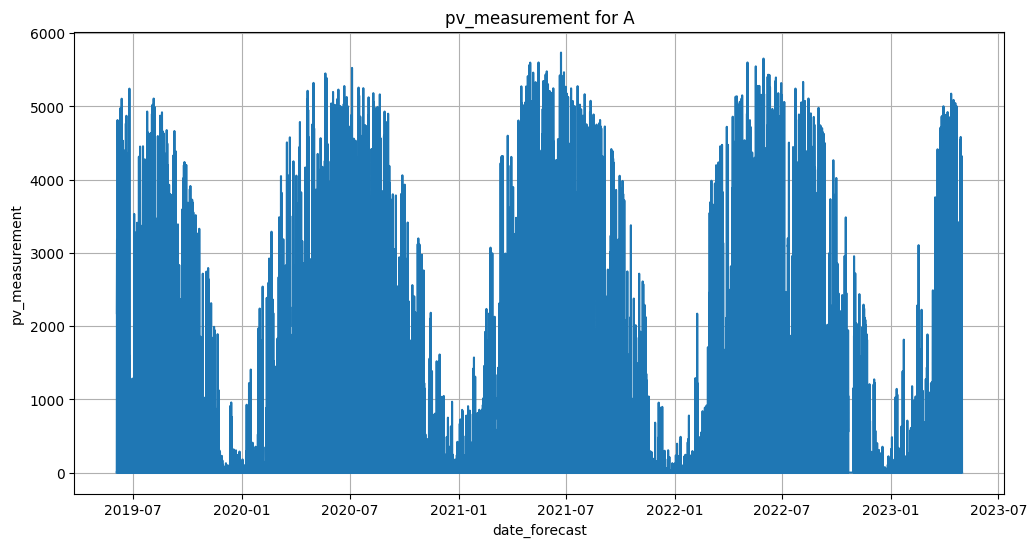

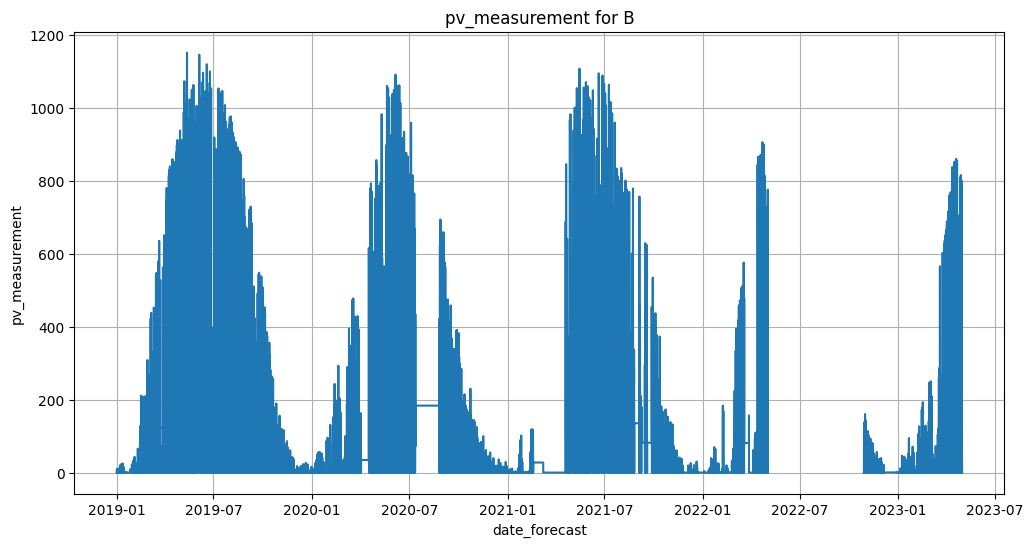

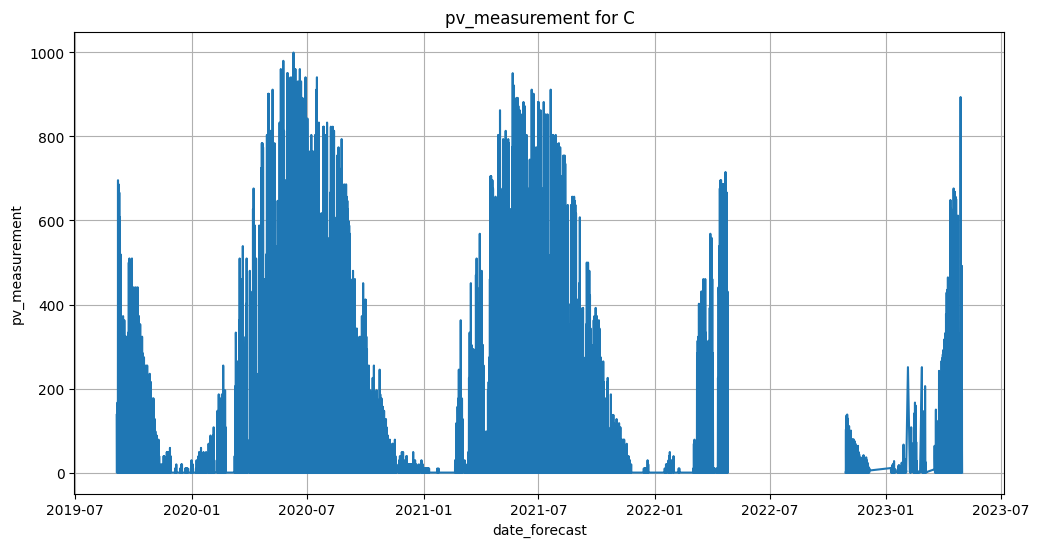

In [9]:
plt.figure(figsize=(12, 6)) 
plt.plot(train_a['time'], train_a['pv_measurement'])
plt.title('pv_measurement for A')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

plt.figure(figsize=(12, 6)) 
plt.plot(train_b['time'], train_b['pv_measurement'])
plt.title('pv_measurement for B')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

plt.figure(figsize=(12, 6)) 
plt.plot(train_c['time'], train_c['pv_measurement'])
plt.title('pv_measurement for C')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()   

# Réorganisation des df :

In [10]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

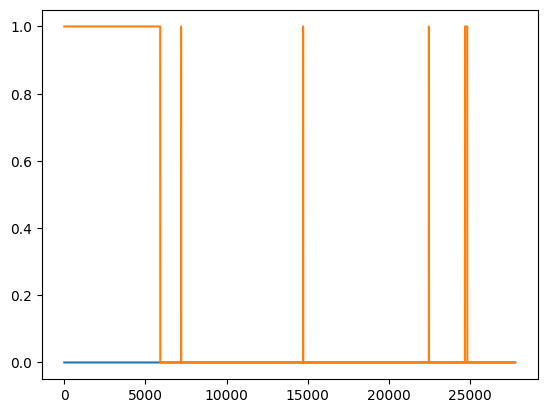

In [11]:
plt.plot(train_c.isna())

In [12]:
train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test.rename(columns={'time': 'date_forecast'}, inplace=True)

train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [13]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

# Analyse des Nan

In [14]:
X_train_observed_a['snow_density:kgm3'].isna().sum()/len(X_train_observed_a)

0.9770453951748139

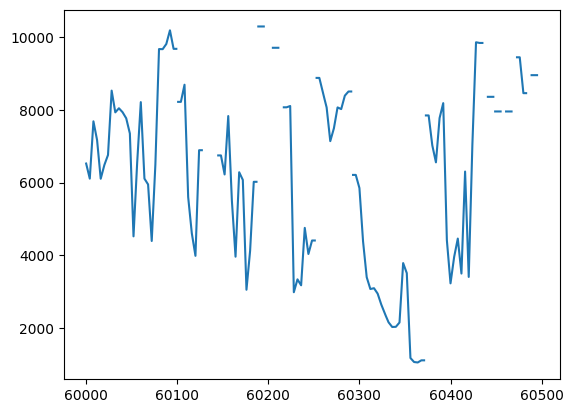

In [15]:
plt.plot(X_train_observed_a['ceiling_height_agl:m'][60000:60500])
#.plot(X_train_observed_a_nan['ceiling_height_agl:m'][60000:60500],ls="--")
#plt.plot(X_train_observed_a['cloud_base_agl:m'][60000:62000].isna())

In [16]:
X_train_observed_a.isna().sum(axis=0)/len(X_train_observed_a)

date_forecast                     0.000000
absolute_humidity_2m:gm3          0.000000
air_density_2m:kgm3               0.000000
ceiling_height_agl:m              0.187471
clear_sky_energy_1h:J             0.000000
clear_sky_rad:W                   0.000000
cloud_base_agl:m                  0.067971
dew_or_rime:idx                   0.000000
dew_point_2m:K                    0.000000
diffuse_rad:W                     0.000000
diffuse_rad_1h:J                  0.000000
direct_rad:W                      0.000000
direct_rad_1h:J                   0.000000
effective_cloud_cover:p           0.000000
elevation:m                       0.000000
fresh_snow_12h:cm                 0.000000
fresh_snow_1h:cm                  0.000000
fresh_snow_24h:cm                 0.000000
fresh_snow_3h:cm                  0.000000
fresh_snow_6h:cm                  0.000000
is_day:idx                        0.000000
is_in_shadow:idx                  0.000000
msl_pressure:hPa                  0.000000
precip_5min

**Conclusion** de l'analyse :    
- Il y a 3 variables avec des Nan
- Snow density est vide à 98% on la supprime
- les deux autres sont vide à 7 et 19% et ce sont des points manquant (problème dans la prise de mesure probablement)
- on décide donc de les compléter par prolongement (moyenne des points environnant)

In [17]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [18]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

In [19]:
X_train_observed_a_nan.isna().sum(axis=0)/len(X_train_observed_a_nan)

date_forecast                     0.0
absolute_humidity_2m:gm3          0.0
air_density_2m:kgm3               0.0
ceiling_height_agl:m              0.0
clear_sky_energy_1h:J             0.0
clear_sky_rad:W                   0.0
cloud_base_agl:m                  0.0
dew_or_rime:idx                   0.0
dew_point_2m:K                    0.0
diffuse_rad:W                     0.0
diffuse_rad_1h:J                  0.0
direct_rad:W                      0.0
direct_rad_1h:J                   0.0
effective_cloud_cover:p           0.0
elevation:m                       0.0
fresh_snow_12h:cm                 0.0
fresh_snow_1h:cm                  0.0
fresh_snow_24h:cm                 0.0
fresh_snow_3h:cm                  0.0
fresh_snow_6h:cm                  0.0
is_day:idx                        0.0
is_in_shadow:idx                  0.0
msl_pressure:hPa                  0.0
precip_5min:mm                    0.0
precip_type_5min:idx              0.0
pressure_100m:hPa                 0.0
pressure_50m

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [20]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [21]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [22]:
split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [23]:
split_date_a = pd.to_datetime("2021-04-15")
split_date2_a = pd.to_datetime("2021-08-15")

split_date_b = pd.to_datetime("2019-04-15")
split_date2_b = pd.to_datetime("2019-08-15")

split_date_c = pd.to_datetime("2021-04-15")
split_date2_c = pd.to_datetime("2021-08-15")

In [24]:
# on coupe nos dataframe à une certaine date

# pv_train_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] <= split_date_a].copy()
# pv_test_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] > split_date_a].copy()

# pv_train_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] <= split_date_b].copy()
# pv_test_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] > split_date_b].copy()

# pv_train_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] <= split_date_c].copy()
# pv_test_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] > split_date_c].copy()

pv_train_a = X_total_a_y_nan[(X_total_a_y_nan['date_forecast'] <= split_date_a) | (X_total_a_y_nan['date_forecast'] > split_date2_a)].copy()
pv_test_a = X_total_a_y_nan[(X_total_a_y_nan['date_forecast'] > split_date_a) & (X_total_a_y_nan['date_forecast'] <= split_date2_a)].copy()

pv_train_b = X_total_b_y_nan[(X_total_b_y_nan['date_forecast'] <= split_date_b) | (X_total_b_y_nan['date_forecast'] > split_date2_b)].copy()
pv_test_b = X_total_b_y_nan[(X_total_b_y_nan['date_forecast'] > split_date_b) & (X_total_b_y_nan['date_forecast'] <= split_date2_b)].copy()

pv_train_c = X_total_c_y_nan[(X_total_c_y_nan['date_forecast'] <= split_date_c) | (X_total_c_y_nan['date_forecast'] > split_date2_c)].copy()
pv_test_c = X_total_c_y_nan[(X_total_c_y_nan['date_forecast'] > split_date_c) & (X_total_c_y_nan['date_forecast'] <= split_date2_c)].copy()


print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100)
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100)
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100)

train_a : (31117, 47)
test_a : (2928, 47)
Rapport test/total : 8.6
train_b : (24311, 47)
test_b : (2852, 47)
Rapport test/total : 10.5
train_c : (18774, 47)
test_c : (2928, 47)
Rapport test/total : 13.5


## Changement type de la date_forecast

In [25]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [26]:
pv_train_a.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm',
       'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p',
       'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms',
       'wind_speed_v_10m:ms

In [27]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [28]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Conversion du type de la date

In [29]:
# X_train_a[('date_forecast')] = X_train_a[('date_forecast')].values.astype("float64")
# X_train_b[('date_forecast')] = X_train_b[('date_forecast')].values.astype("float64")
# X_train_c[('date_forecast')] = X_train_c[('date_forecast')].values.astype("float64")
# X_test_a[('date_forecast')] = X_test_a[('date_forecast')].values.astype("float64")
# X_test_b[('date_forecast')] = X_test_b[('date_forecast')].values.astype("float64")
# X_test_c[('date_forecast')] = X_test_c[('date_forecast')].values.astype("float64")

## Normalisation

In [30]:
from sklearn.preprocessing import Normalizer, RobustScaler

def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      scaler = Normalizer()
      # scaler = RobustScaler()
      # scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : normalized_data = scaler.transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [31]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True)

In [32]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [33]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [34]:
# Créez un modèle XGBoost
reg_a = xgb.XGBRegressor(n_estimators=10000)

# Entraînez le modèle et suivez l'évolution des erreurs
reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

reg_b = xgb.XGBRegressor(n_estimators=10000)
reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

reg_c = xgb.XGBRegressor(n_estimators=10000)
reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)

[0]	validation_0-rmse:831.44697	validation_1-rmse:1367.74078
[1]	validation_0-rmse:662.17068	validation_1-rmse:1090.77716
[2]	validation_0-rmse:555.08745	validation_1-rmse:917.68585
[3]	validation_0-rmse:491.67949	validation_1-rmse:810.63546
[4]	validation_0-rmse:452.47418	validation_1-rmse:742.74144
[5]	validation_0-rmse:428.57510	validation_1-rmse:703.65268
[6]	validation_0-rmse:413.54325	validation_1-rmse:681.29861
[7]	validation_0-rmse:402.96087	validation_1-rmse:666.42815
[8]	validation_0-rmse:395.87784	validation_1-rmse:655.46618
[9]	validation_0-rmse:388.15985	validation_1-rmse:648.68450
[10]	validation_0-rmse:382.84583	validation_1-rmse:647.49460
[11]	validation_0-rmse:375.85040	validation_1-rmse:642.75314
[12]	validation_0-rmse:370.51245	validation_1-rmse:637.03608


[13]	validation_0-rmse:367.39426	validation_1-rmse:636.40267
[14]	validation_0-rmse:362.69941	validation_1-rmse:635.52336
[15]	validation_0-rmse:356.65181	validation_1-rmse:636.59391
[16]	validation_0-rmse:352.33088	validation_1-rmse:637.53138
[17]	validation_0-rmse:348.62799	validation_1-rmse:638.64693
[18]	validation_0-rmse:345.75310	validation_1-rmse:638.57482
[19]	validation_0-rmse:342.75521	validation_1-rmse:638.36293
[20]	validation_0-rmse:340.67716	validation_1-rmse:639.56534
[21]	validation_0-rmse:336.98759	validation_1-rmse:642.06324
[22]	validation_0-rmse:334.23172	validation_1-rmse:642.30468
[23]	validation_0-rmse:331.88852	validation_1-rmse:643.15398
[24]	validation_0-rmse:328.33322	validation_1-rmse:644.40662
[25]	validation_0-rmse:326.32554	validation_1-rmse:644.87174
[26]	validation_0-rmse:323.67745	validation_1-rmse:648.59876
[27]	validation_0-rmse:320.09932	validation_1-rmse:648.22089
[28]	validation_0-rmse:318.46319	validation_1-rmse:649.08978
[29]	validation_0-rmse:3

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:309.80688	validation_1-rmse:649.01908
[32]	validation_0-rmse:306.35971	validation_1-rmse:652.70313
[33]	validation_0-rmse:304.68795	validation_1-rmse:654.37796
[34]	validation_0-rmse:302.95077	validation_1-rmse:654.50108
[35]	validation_0-rmse:301.75679	validation_1-rmse:655.17782
[36]	validation_0-rmse:299.18479	validation_1-rmse:656.77657
[37]	validation_0-rmse:296.16766	validation_1-rmse:658.79400
[38]	validation_0-rmse:294.14363	validation_1-rmse:659.26406
[39]	validation_0-rmse:291.88017	validation_1-rmse:659.52616
[40]	validation_0-rmse:288.84805	validation_1-rmse:659.70292
[41]	validation_0-rmse:287.07980	validation_1-rmse:661.33973
[42]	validation_0-rmse:286.58490	validation_1-rmse:661.19463
[43]	validation_0-rmse:284.65559	validation_1-rmse:661.77001
[44]	validation_0-rmse:283.00859	validation_1-rmse:660.27307
[45]	validation_0-rmse:281.50411	validation_1-rmse:660.77629
[46]	validation_0-rmse:279.96835	validation_1-rmse:661.91839
[47]	validation_0-rmse:2

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-rmse:37.39188	validation_1-rmse:119.07310
[46]	validation_0-rmse:37.05014	validation_1-rmse:118.99939
[47]	validation_0-rmse:36.65173	validation_1-rmse:119.25922
[48]	validation_0-rmse:36.37194	validation_1-rmse:119.41263
[49]	validation_0-rmse:35.90745	validation_1-rmse:119.63590
[50]	validation_0-rmse:35.63716	validation_1-rmse:119.66873
[51]	validation_0-rmse:35.38192	validation_1-rmse:119.91564
[52]	validation_0-rmse:35.05559	validation_1-rmse:120.41874
[53]	validation_0-rmse:34.69060	validation_1-rmse:120.42456
[54]	validation_0-rmse:34.42811	validation_1-rmse:120.45842
[55]	validation_0-rmse:34.30022	validation_1-rmse:120.56545
[56]	validation_0-rmse:34.00973	validation_1-rmse:120.53660
[57]	validation_0-rmse:33.69494	validation_1-rmse:120.34894
[58]	validation_0-rmse:33.31221	validation_1-rmse:120.44140
[59]	validation_0-rmse:32.97871	validation_1-rmse:120.44897
[60]	validation_0-rmse:32.89708	validation_1-rmse:120.38378
[61]	validation_0-rmse:32.64234	validati

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-rmse:27.03192	validation_1-rmse:98.89055
[48]	validation_0-rmse:26.65301	validation_1-rmse:98.81967
[49]	validation_0-rmse:26.33291	validation_1-rmse:98.71034
[50]	validation_0-rmse:25.97792	validation_1-rmse:98.60813
[51]	validation_0-rmse:25.57988	validation_1-rmse:98.83248
[52]	validation_0-rmse:25.36563	validation_1-rmse:98.78619
[53]	validation_0-rmse:25.03528	validation_1-rmse:98.80351
[54]	validation_0-rmse:24.85706	validation_1-rmse:98.83915
[55]	validation_0-rmse:24.54415	validation_1-rmse:98.90747
[56]	validation_0-rmse:24.14051	validation_1-rmse:98.97773
[57]	validation_0-rmse:23.92572	validation_1-rmse:99.10417
[58]	validation_0-rmse:23.70397	validation_1-rmse:99.14000


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

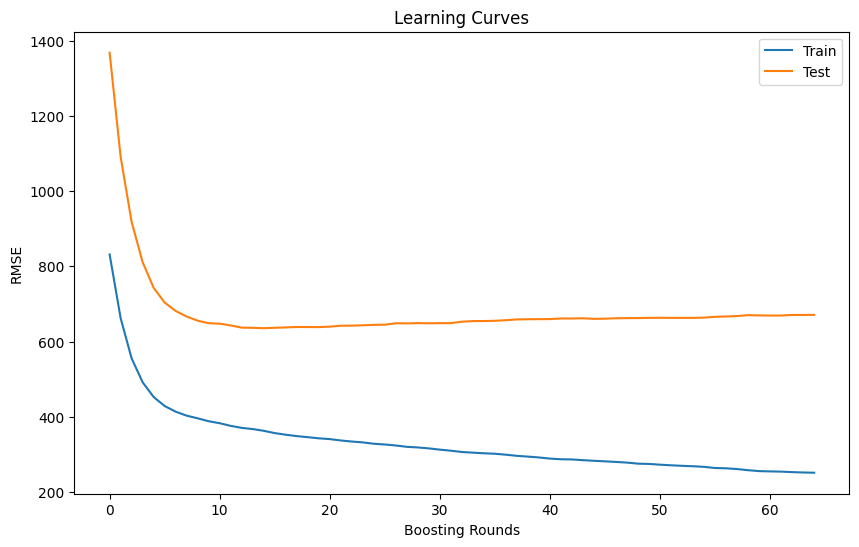

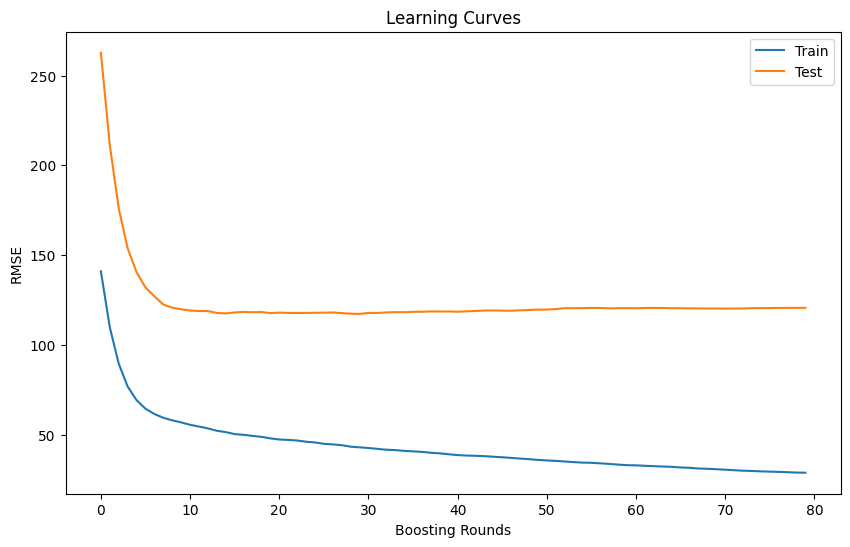

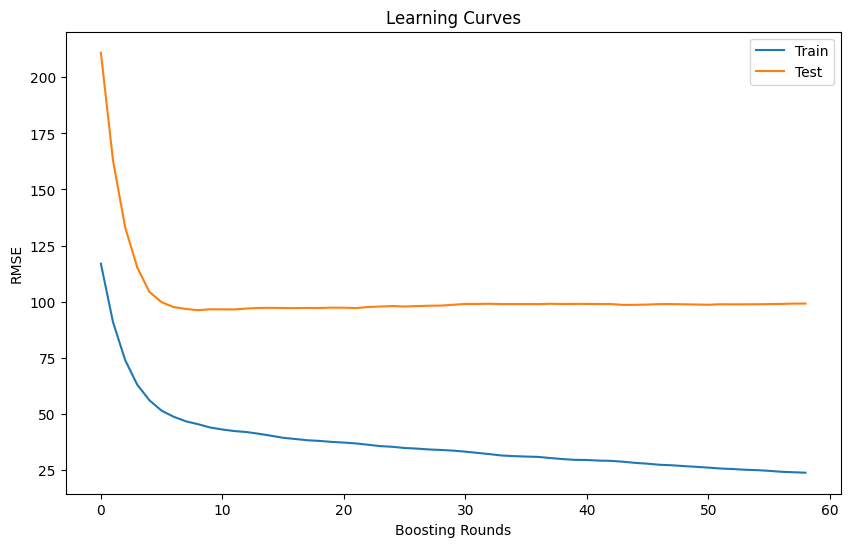

In [35]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_b = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

min_error_c = min(test_errors)
# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

In [36]:
min_error_a, min_error_b, min_error_c

(635.5233551817754, 117.23885276848634, 96.18672360163899)

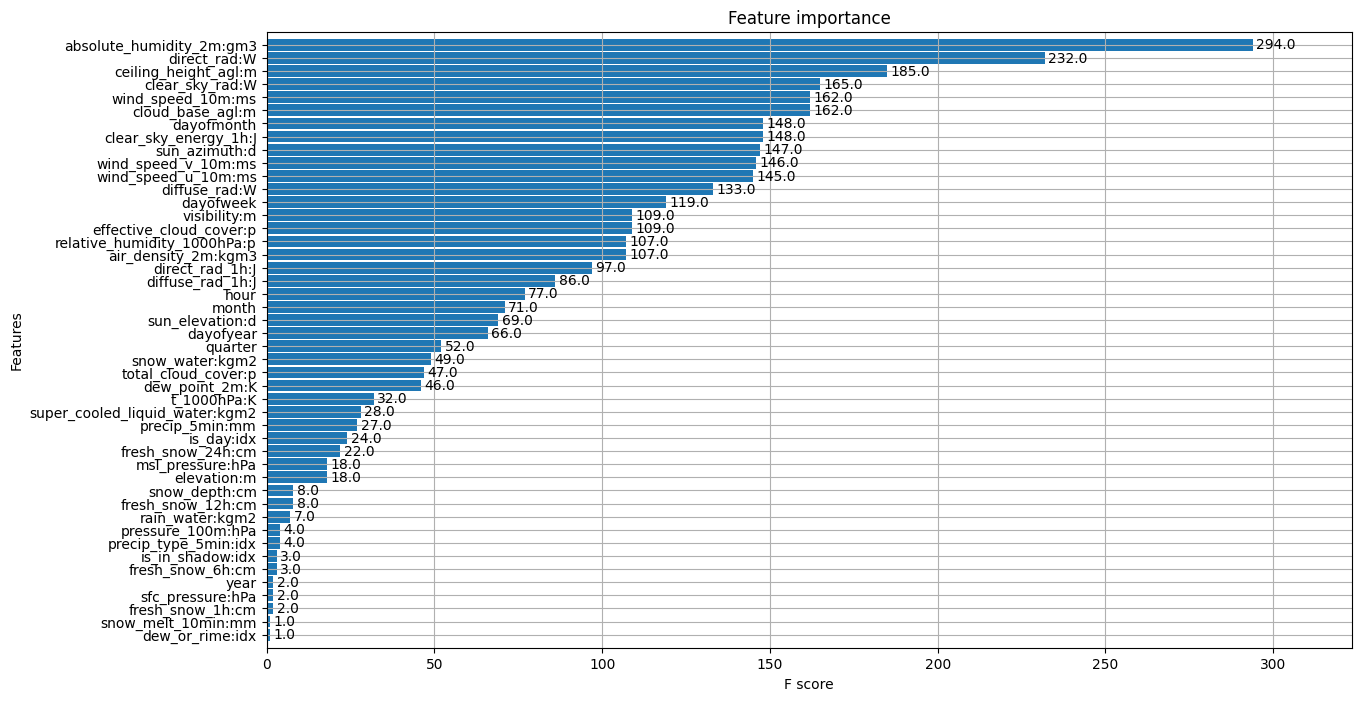

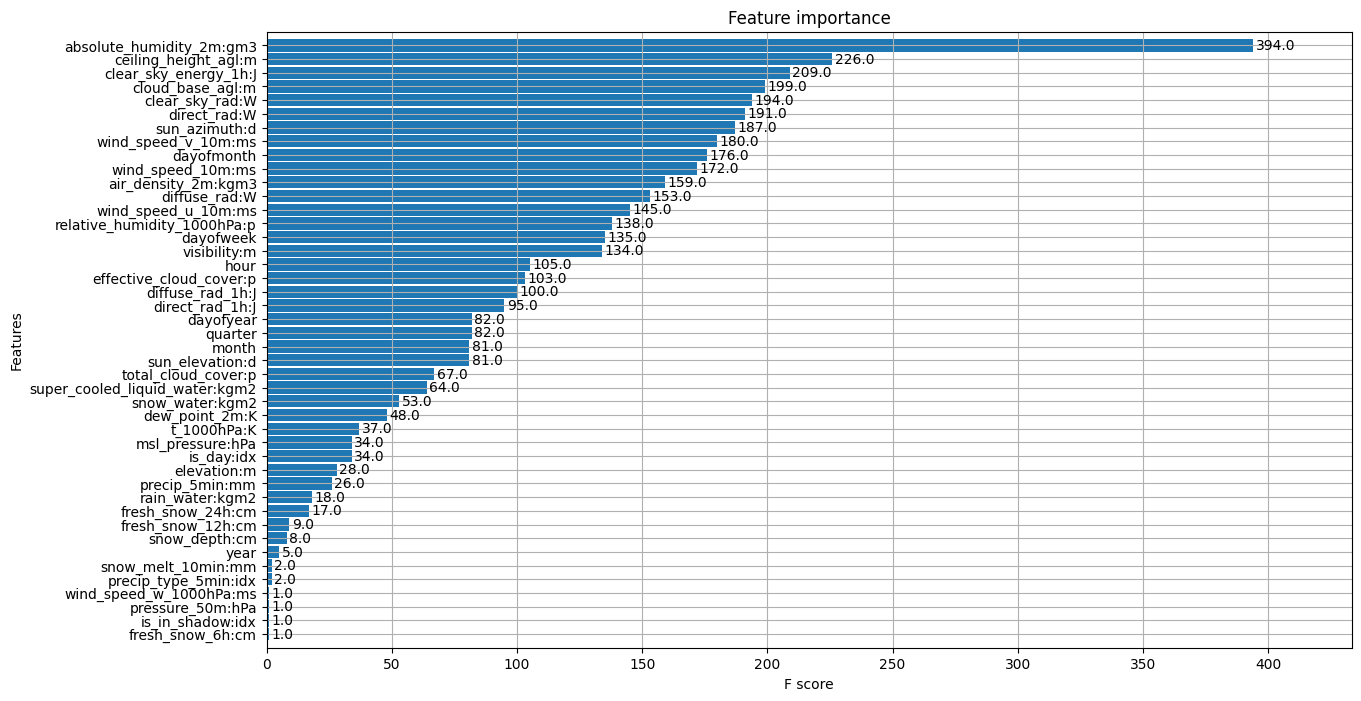

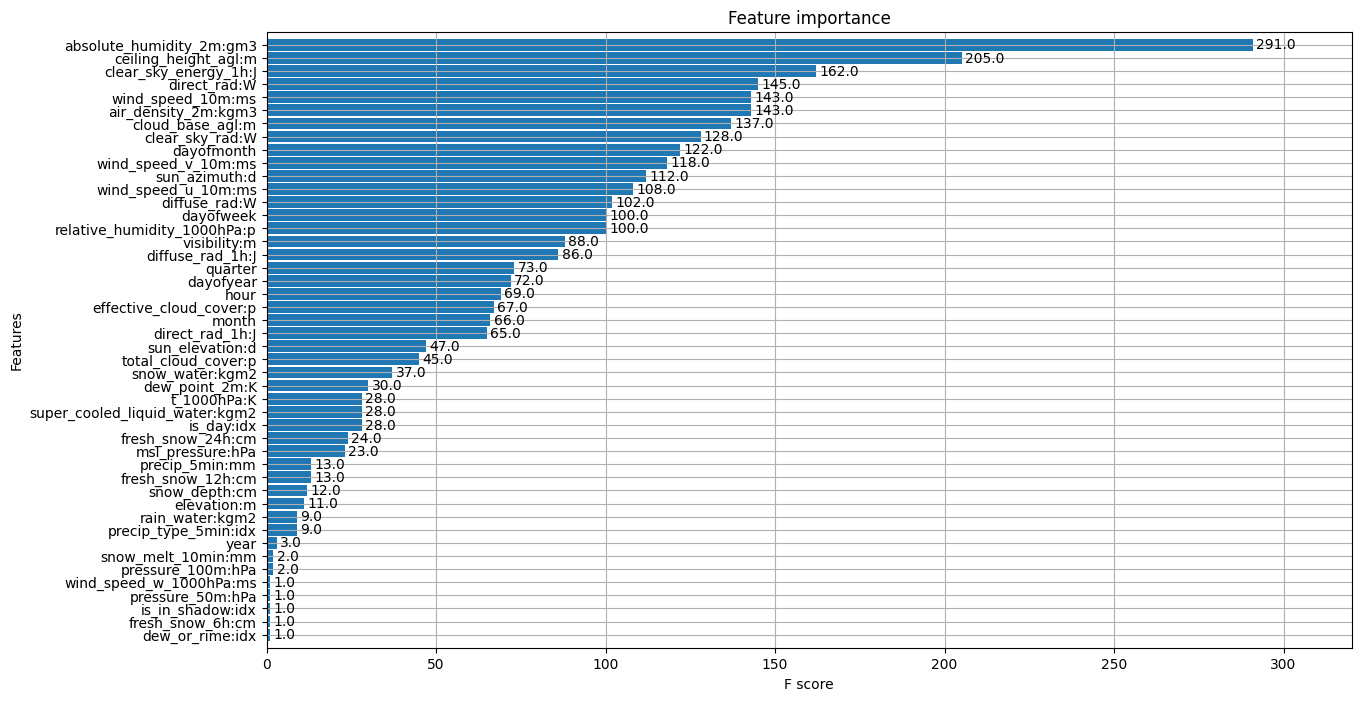

In [37]:
plot_importance(reg_a, height=.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_b, height=0.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_c, height=0.9)
plt.gcf().set_size_inches(14, 8)

In [38]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a_norm)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b_norm)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c_norm)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

In [40]:
mae_a = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction']))
mae_b = np.mean(np.abs(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction']))
mae_c = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_c['pv_measurement_prediction']))

mae = (mae_a + mae_b + mae_c) / 3
print("MAE a:", mae_a, "MAE b:", mae_b, "MAE c:", mae_c)
print("MAE on test set:", mae)

MAE a: 373.2406340103527 MAE b: 69.012468547002 MAE c: 239.88759622345694
MAE on test set: 227.38023292693723


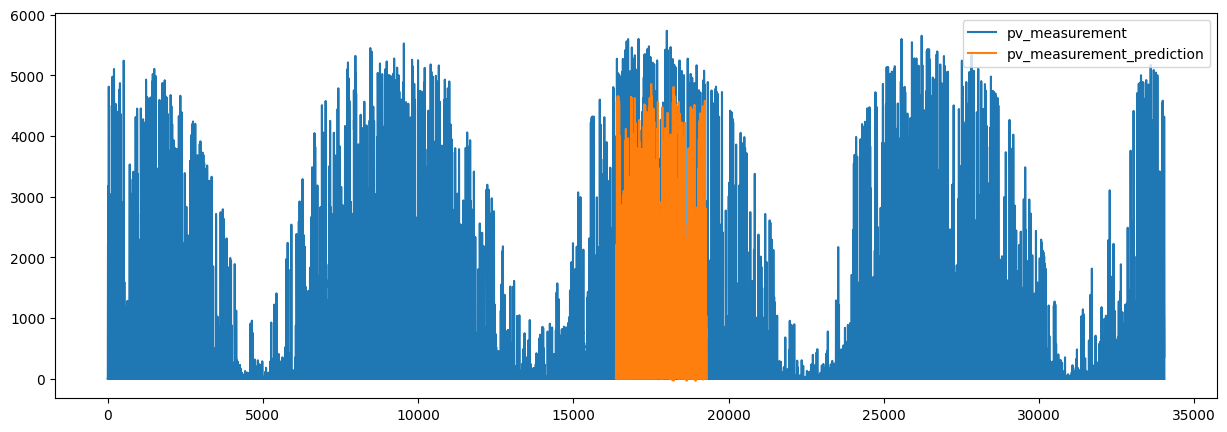

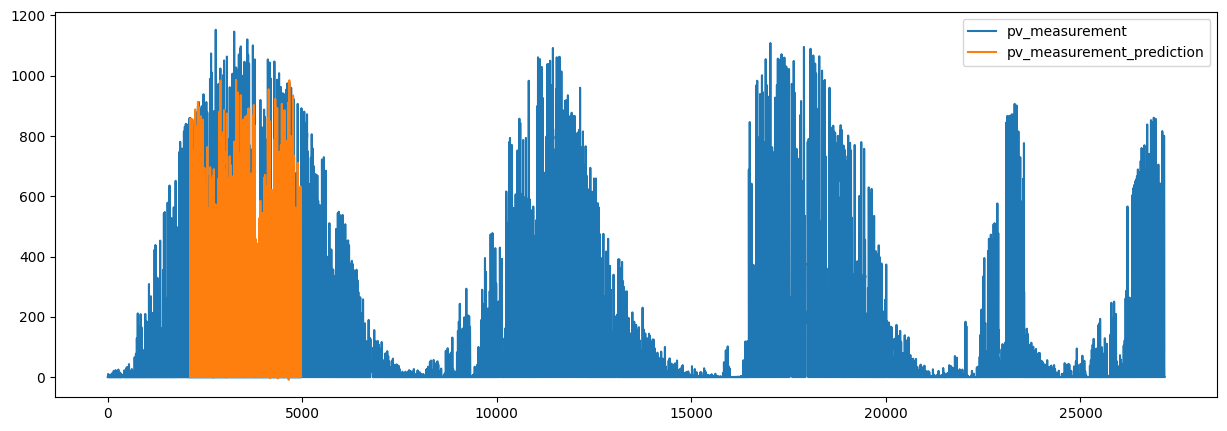

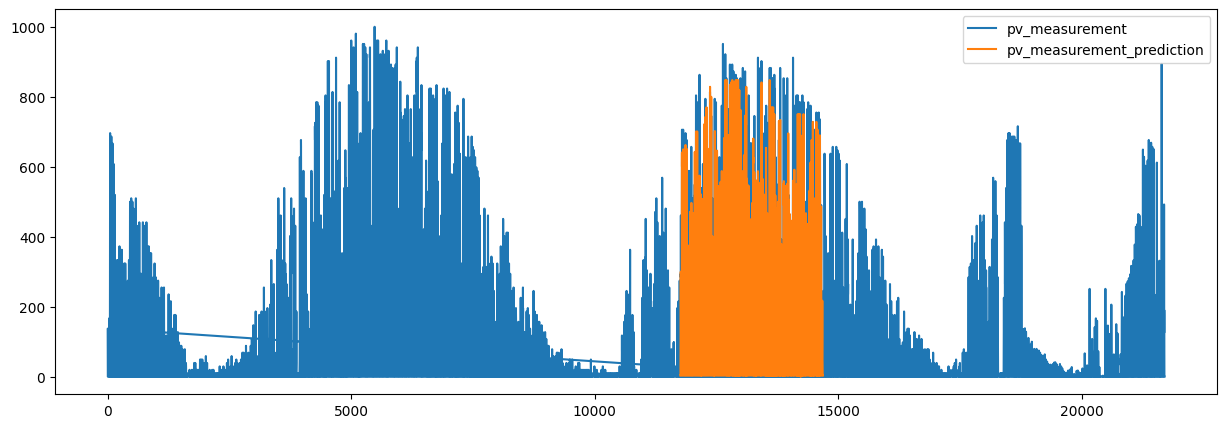

In [41]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))

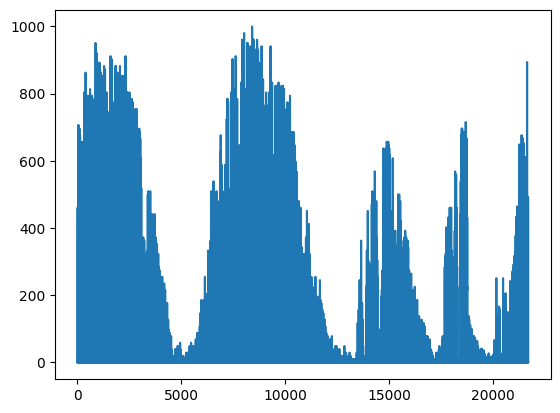

In [42]:
np_pv_c = np.array(pv_all_c['pv_measurement'])
plt.plot(np_pv_c)

# Export sur Kaggle

In [43]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [44]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [45]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler)
  return X_test

In [46]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [47]:
result_A = reg_a.predict(X_test_a_test)
result_B = reg_b.predict(X_test_b_test)
result_C = reg_c.predict(X_test_c_test)

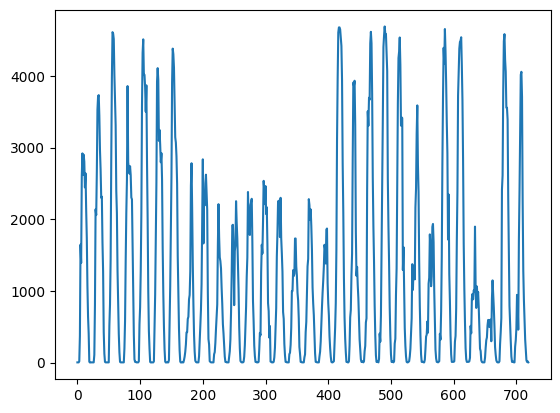

In [48]:
plt.plot(result_A)

In [49]:
nom_fichier = 'XGBoost_Valentin_V2'
repertoire = path
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [50]:
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [51]:
negative_mask = result < 0
result[negative_mask] = 0

In [52]:
nom_fichier = f'XGBoost_Arthur_split_dates_{split_date_a}_{split_date_b}_and_{split_date_c}'
repertoire = path
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

In [53]:
result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [54]:
negative_mask2 = result2 < 0
result2[negative_mask2] = 0

**Liste amélioration V2** :

- Gestion zones continues B et C (suppression)
-